# Analysis of BRCA pools

This notebook describes the analysis of the tiling screens of BRCA1 and BRCA2. This version of the notebook includes data from HAP1 (screened with no drug) and MELJUSO (screened with cisplatin and talazoparib).

The starting data are already filtered to exclude sgRNAs that have >5 Match Bin I off-targets and sgRNAs for which the lognorm of the pDNA is > 3 SD from the mean. To obtain these data from the Supplementary Tables, run the Screening_Data_Processign notebook.

In [6]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import pearsonr, gaussian_kde
from math import log, floor, ceil
import base_edit_functions_v3 as be
from scipy import arange
from sklearn.metrics import auc, roc_curve, roc_auc_score

# Set default settings for plotting
sns.set(style='ticks',context='paper')
mpl.rc('pdf', fonttype=42)
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

In [7]:
brca1 = pd.read_csv('../Data/Filtered_LFC_files/Table_S2_filtered_BRCA1_v1.csv')
brca2 = pd.read_csv('../Data/Filtered_LFC_files/Table_S2_filtered_BRCA2_v1.csv')

### Cell line correlations

First, we look at the correlation between the two cell lines.

In [8]:
def generate_scatter(xcol,ycol,scores,xlabel,ylabel,title,lims,name):
    fig,ax = plt.subplots(figsize=(2,2))
    x = scores[xcol]
    y = scores[ycol]
    corr = np.round(pearsonr(x, y)[0],2)
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    ax.scatter(x, y, c=z, s=8, edgecolor='', cmap='viridis')
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel(xlabel,fontsize=8)
    ax.set_ylabel(ylabel,fontsize=8)
    ax.set_title(title)
    ax.text(0.98,0,'r = '+str(corr), fontsize=8,ha='right',va='bottom',transform=ax.transAxes)
    #UNDO
    #fig.savefig('../Figures/Fig2-3_BRCA/Panels/'+name,bbox_inches='tight',transparent=True)
    return fig,ax


First, we can examine the correlation between the different cell lines and drug arms.

## BRCA1

In [33]:
corr = np.round(pearsonr(brca1['MELJUSO;Talazoparib;MedABC;LFC_pdna'], brca1['MELJUSO;Cisplatin;MedABC;LFC_pdna'])[0],2)
print 'Correlation between MELJUSO talazoparib and MELJUSO cisplatin = ' + str(corr)

Correlation between MELJUSO talazoparib and MELJUSO cisplatin = 0.94


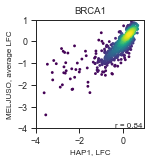

In [10]:
fig,ax = generate_scatter(xcol='HAP1;Dropout;MedABC;LFC_pdna',
                   ycol='MELJUSO;AvgTalazoparib_Cisplatin;LFC_pdna',
                   scores=brca1,
                   xlabel='HAP1, LFC',
                   ylabel='MELJUSO, average LFC',
                   title='BRCA1',
                   lims=[-4,1],
                   name='HAP1_Meljuso_BRCA1.pdf')

## BRCA2

In [32]:
corr = np.round(pearsonr(brca2['MELJUSO;Talazoparib;MedABC;LFC_pdna'], brca2['MELJUSO;Cisplatin;MedABC;LFC_pdna'])[0],2)
print 'Correlation between MELJUSO talazoparib and MELJUSO cisplatin = ' + str(corr)

Correlation between MELJUSO talazoparib and MELJUSO cisplatin = 0.97


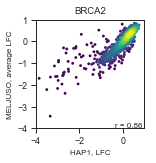

In [12]:
fig,ax = generate_scatter(xcol='HAP1;Dropout;MedABC;LFC_pdna',
                   ycol='MELJUSO;AvgTalazoparib_Cisplatin;LFC_pdna',
                   scores=brca2,
                   xlabel='HAP1, LFC',
                   ylabel='MELJUSO, average LFC',
                   title='BRCA2',
                   lims=[-4,1],
                   name='HAP1_Meljuso_BRCA2.pdf')

### Histograms

Next, we create some ridgeplots to show the depletion of the different sgRNA categories.

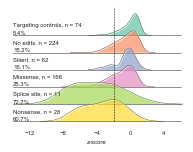

<Figure size 432x288 with 0 Axes>

In [34]:
fig,ax = be.make_ridgeplots(
            data = brca1,
            col = 'AvgHAP1_MELJUSO;LFC_pdna;z-score',
            lims = [-14,6],
            ticks = [-12,-8,-4,0,4],
            xlabel = 'z-score',
            geneset = ['BRCA1'],
            cutoff = -2,
            control_geneset = ['Intergenic control'])
#UNDO
#fig.savefig('../Figures/Fig2-3_BRCA/BRCA1_ridgeplot_v2.pdf',transparent=True,bbox_inches='tight')

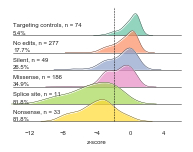

<Figure size 432x288 with 0 Axes>

In [14]:
fig,ax = be.make_ridgeplots(
            data = brca2,
            col = 'AvgHAP1_MELJUSO;LFC_pdna;z-score',
            lims = [-14,6],
            ticks = [-12,-8,-4,0,4],
            xlabel = 'z-score',
            geneset = ['BRCA2'],
            cutoff = -2,
            control_geneset = ['Intergenic control'])
#UNDO
#fig.savefig('../Figures/Fig2-3_BRCA/BRCA2_ridgeplot_v2.pdf',transparent=True,bbox_inches='tight')

# Sensitivity and specificity analysis

In [15]:
def brca_roc(input_data,colname,title):
    df = input_data.copy()
    fig,ax = plt.subplots(figsize = (1.7,1.7))

    # Define true positives and true negatives
    df[str('true_pos')] = np.nan
    df.loc[df['SNP clinical significance'].isin(['Pathogenic',
                                                 'Pathogenic/Likely pathogenic',
                                                 'Likely pathogenic']),str('true_pos')] = 1
    df.loc[df['SNP clinical significance'].isin(['Benign',
                                                 'Benign/Likely benign',
                                                 'Likely benign']),str('true_pos')] = 0
    
    # Calculate percent rank
    df[str('pctrank')] = df[colname].rank(ascending=False,pct=True)
    print 'true positive n = ' + str(len(df[df[str('true_pos')] == 1]))
    print 'false positive n = ' + str(len(df[df[str('true_pos')] == 0]))  

    data = df[df[str('true_pos')].isin([0,1])]
    
    fpr, tpr, thresholds = roc_curve(data['true_pos'], data['pctrank'])
    roc_auc = auc(fpr, tpr)
    print roc_auc
    plt.plot(fpr, tpr,color='black')

    # Tidy up plot
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    ax.set_xticks([0,0.5,1])
    ax.set_yticks([0,0.5,1])
    plt.xlabel('False positive rate\n1 - specificity',fontsize=8)
    plt.ylabel('True positive rate\nSensitivity',fontsize=8)
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.tick_params(width = 0.5,length = 4)

    plt.title(title,y = 1.0,fontsize = 8)
    plt.show()
    plt.close()
    return fig,ax

For this analysis, we join on the "clinvar_annotations" files for BRCA1 and BRCA2. These are files of ClinVar variants that have one variant per row (i.e. an sgRNA can appear multiple times).

In [16]:
sns.set_style('ticks')
brca1_clinvar_annot = pd.read_table('../Data/Annotations/0423_GC_filter_annotations/BRCA1_0422_20-04-22-17-23-50/clinvar_annotations_BRCA1_0422.txt')
brca2_clinvar_annot = pd.read_table('../Data/Annotations/0423_GC_filter_annotations/BRCA2_0422_20-04-22-17-24-24/clinvar_annotations_BRCA2_0422.txt')

The "Same amino acid change", "Same nucleotide change," "Same amino acid position," and "Same amino acid change" columns provide information about the similarity of the SNP to the edit that is predicted by the sgRNA. For the purposes of this analysis, we will require a stringent match: Same nucleotide position == True, Same nucleotide change == True, and Same amino acid change != False (this is to include splice sites / introns, which are "blanks"). We don't require that Same amino acid position == True to account for differences in transcripts.

In [17]:
# Filter for stringent matches
brca1_clinvar_annot = brca1_clinvar_annot.loc[(brca1_clinvar_annot['Same nucleotide position'] == True) &
                                              (brca1_clinvar_annot['Same nucleotide change'] == True) &
                                              (brca1_clinvar_annot['Same amino acid change'] != False),:]

brca2_clinvar_annot = brca2_clinvar_annot.loc[(brca2_clinvar_annot['Same nucleotide position'] == True) &
                                              (brca2_clinvar_annot['Same nucleotide change'] == True) &
                                              (brca2_clinvar_annot['Same amino acid change'] != False),:]

# Look at a subset of the clinvar_annot dataframe
print brca1_clinvar_annot.shape
brca1_clinvar_annot[['sgRNA sequence','Edit nucleotide','Edit nucleotide position(s)','Mutation category','SNP nucleotide position',
                     'SNP amino acid change','SNP reference allele','SNP alternate allele','SNP clinical significance','Same nucleotide position',
                     'Same nucleotide change','Same amino acid position','Same amino acid change']].head()

(195, 28)


,sgRNA sequence,Edit nucleotide,Edit nucleotide position(s),Mutation category,SNP nucleotide position,SNP amino acid change,SNP reference allele,SNP alternate allele,SNP clinical significance,Same nucleotide position,Same nucleotide change,Same amino acid position,Same amino acid change
0,AAATCTTAGAGTGTCCCATC,C_5,43124034,Silent,43124034.0,Ile21Ile,G,A,Likely benign,True,True,True,True
5,CCAGACTAGCAGGGTAGGGG,C_6,43115780,Splice-acceptor,43115780.0,NaN,C,T,Pathogenic/Likely pathogenic,True,True,NaN,NaN
6,CCCCCCCTACCCTGCTAGTC,C_6,43115792,Intron,43115792.0,NaN,G,A,Conflicting interpretations of pathogenicity,True,True,NaN,NaN
10,CCCCCCCTACCCTGCTAGTC,C_5,43115793,Intron,43115793.0,NaN,G,A,Benign/Likely benign,True,True,NaN,NaN
12,CCCCCCCTACCCTGCTAGTC,C_7,43115791,Intron,43115791.0,NaN,G,A,Likely benign,True,True,NaN,NaN


In [18]:
# Merge onto clinvar dataframe
brca1_clinvar = pd.merge(brca1,brca1_clinvar_annot,how='left',on='sgRNA sequence')
brca2_clinvar = pd.merge(brca2,brca2_clinvar_annot,how='left',on='sgRNA sequence')

Next, we obtain our gold standard test of true positives (Pathogenic / Likely pathogenic) and true negatives (Benign / Likely benign) for BRCA1 and BRCA2. For true negatives, we also require that sgRNAs introduce the edit uniquely, to avoid possible confounding effects from other mutations. Then, for each variant, we obtain a single score for each variant by taking the mean of all sgRNAs predicted to introduce that variant.

In [19]:
def get_average_per_variant(variant,df,col):
    return df.loc[df['SNP nucleotide position'] == variant,col].mean()

In [20]:
# Get BRCA1 true positive set
print 'Pathogenic / Likely pathogenic'
brca1_true_pos = brca1_clinvar.loc[(brca1_clinvar['SNP clinical significance'].isin(['Pathogenic','Pathogenic/Likely pathogenic','Likely pathogenic']))]

# Number of unique sgRNAs
print 'Number of unique sgRNAs = ' + str(len(set(brca1_true_pos['Construct Barcode'].tolist())))

# Number of unique variants
print 'Number of unique variants = ' + str(len(set(brca1_true_pos['Edit nucleotide position(s)'].tolist())))

brca1_true_pos.loc[:,'Average score per variant'] = brca1_true_pos.loc[:,'SNP nucleotide position'].apply(get_average_per_variant,args=(brca1_true_pos,'AvgHAP1_MELJUSO;LFC_pdna;z-score',))
brca1_true_pos = brca1_true_pos.loc[:,['Edit nucleotide position(s)','SNP clinical significance','sgRNA amino acid change','Average score per variant']].drop_duplicates(subset='Edit nucleotide position(s)')


Pathogenic / Likely pathogenic
Number of unique sgRNAs = 45
Number of unique variants = 36


/Users/rhanna/anaconda3/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/rhanna/anaconda3/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [21]:
# Get BRCA1 true negative set
print 'Benign / Likely benign'
brca1_true_neg = brca1_clinvar.loc[(brca1_clinvar['# edits'] == 1) & 
                                   (brca1_clinvar['SNP clinical significance'].isin(['Benign','Benign/Likely benign','Likely benign']))]
# Number of unique sgRNAs
print 'Number of unique sgRNAs = ' + str(len(set(brca1_true_neg['Construct Barcode'].tolist())))

# Number of unique variants
print 'Number of unique variants = ' + str(len(set(brca1_true_neg['Edit nucleotide position(s)'].tolist())))

brca1_true_neg.loc[:,'Average score per variant'] = brca1_true_neg.loc[:,'SNP nucleotide position'].apply(get_average_per_variant,args=(brca1_true_neg,'AvgHAP1_MELJUSO;LFC_pdna;z-score',))
brca1_true_neg = brca1_true_neg.loc[:,['Edit nucleotide position(s)','SNP clinical significance','sgRNA amino acid change','Average score per variant']].drop_duplicates(subset='Edit nucleotide position(s)')


Benign / Likely benign
Number of unique sgRNAs = 23
Number of unique variants = 19


In [22]:
# Get BRCA2 true positive set
print 'Pathogenic / Likely pathogenic'
brca2_true_pos = brca2_clinvar.loc[(brca2_clinvar['SNP clinical significance'].isin(['Pathogenic','Pathogenic/Likely pathogenic','Likely pathogenic']))]

# Number of unique sgRNAs
print 'Number of unique sgRNAs = ' + str(len(set(brca2_true_pos['Construct Barcode'].tolist())))

# Number of unique variants
print 'Number of unique variants = ' + str(len(set(brca2_true_pos['Edit nucleotide position(s)'].tolist())))

brca2_true_pos.loc[:,'Average score per variant'] = brca2_true_pos.loc[:,'SNP nucleotide position'].apply(get_average_per_variant,args=(brca2_true_pos,'AvgHAP1_MELJUSO;LFC_pdna;z-score',))
brca2_true_pos = brca2_true_pos.loc[:,['Edit nucleotide position(s)','SNP clinical significance','sgRNA amino acid change','Average score per variant']].drop_duplicates(subset='Edit nucleotide position(s)')
print len(brca2_true_pos)

Pathogenic / Likely pathogenic
Number of unique sgRNAs = 34
Number of unique variants = 31
31


In [23]:
# Get BRCA2 true negative set
print 'Benign / Likely benign'
brca2_true_neg = brca2_clinvar.loc[(brca2_clinvar['# edits'] == 1) & 
                                   (brca2_clinvar['SNP clinical significance'].isin(['Benign','Benign/Likely benign','Likely benign']))]

# Number of unique sgRNAs
print 'Number of unique sgRNAs = ' + str(len(set(brca2_true_neg['Construct Barcode'].tolist())))

# Number of unique variants
print 'Number of unique variants = ' + str(len(set(brca2_true_neg['Edit nucleotide position(s)'].tolist())))

brca2_true_neg.loc[:,'Average score per variant'] = brca2_true_neg.loc[:,'SNP nucleotide position'].apply(get_average_per_variant,args=(brca2_true_neg,'AvgHAP1_MELJUSO;LFC_pdna;z-score',))
brca2_true_neg = brca2_true_neg.loc[:,['Edit nucleotide position(s)','SNP clinical significance','sgRNA amino acid change','Average score per variant']].drop_duplicates(subset='Edit nucleotide position(s)')
print len(brca2_true_neg)

Benign / Likely benign
Number of unique sgRNAs = 24
Number of unique variants = 21
21


In [24]:
brca1_curated = pd.concat([brca1_true_pos,brca1_true_neg])
print 'Total number of "gold standard" BRCA1 variants = ' + str(len(brca1_curated))

brca2_curated = pd.concat([brca2_true_pos,brca2_true_neg])
print 'Total number of "gold standard" BRCA2 variants = ' + str(len(brca2_curated))

Total number of "gold standard" BRCA1 variants = 55
Total number of "gold standard" BRCA2 variants = 52


true positive n = 36
false positive n = 19
0.8538011695906432


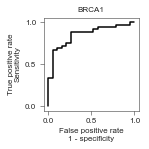

In [25]:
fig,ax = brca_roc(brca1_curated,'Average score per variant','BRCA1')
#UNDO
#fig.savefig('../Figures/Fig2-3_BRCA/Panels/ROC_BRCA1_variant_v1.pdf',bbox_inches='tight',transparent=True)

true positive n = 31
false positive n = 21
0.9585253456221199


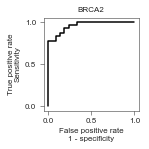

In [26]:
fig,ax = brca_roc(brca2_curated,'Average score per variant','BRCA2')
#UNDO
#fig.savefig('../Figures/Fig2-3_BRCA/Panels/ROC_BRCA2_variant_v1.pdf',bbox_inches='tight',transparent=True)

Finally, we calculate sensitivity and specificity at a z-score threshold of -2.

In [35]:
def get_sens_spec(df,cutoff):
    # sensitivity = tp / all positives
    path_types = ['Pathogenic','Pathogenic/Likely pathogenic','Likely pathogenic']
    tp = len(df[(df['SNP clinical significance'].isin(path_types)) & 
                  (df['Average score per variant'] < -2)])
    all_pos = len(df[(df['SNP clinical significance'].isin(path_types))])
    sensitivity = float(tp)/float(all_pos)
    
    # specificity = tn / all negatives
    benign_types = ['Benign','Benign/Likely benign','Likely benign']
    tn = len(df[(df['SNP clinical significance'].isin(benign_types)) & 
                  (df['Average score per variant'] >= -2)])
    all_neg = len(df[(df['SNP clinical significance'].isin(benign_types))])
    specificity = float(tn)/float(all_neg)
    
    return sensitivity, specificity


In [38]:
sens, spec = get_sens_spec(brca1_curated, -2)
print 'Sensitivity = ' + str(np.round(sens,2))
print 'Specificity = ' + str(np.round(spec,2))

Sensitivity = 0.69
Specificity = 0.84


In [39]:
sens, spec = get_sens_spec(brca2_curated, -2)
print 'Sensitivity = ' + str(np.round(sens,2))
print 'Specificity = ' + str(np.round(spec,2))

Sensitivity = 0.84
Specificity = 0.86
